# Практическое задание №7 по теме "Интерпретация прогнозов модели (SHAP)".

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для 5 случайных объектов 
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

## Задание №1

Возьмем датасет бинарной классификации вина на хорошее и плохое.

https://www.kaggle.com/datasets/nareshbhat/wine-quality-binary-classification?select=wine.csv

In [2]:
df = pd.read_csv("wine.csv")
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad


## Задание №2

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [5]:
df['quality'].value_counts()

good    855
bad     744
Name: quality, dtype: int64

Обзор:

Датасет сбалансированный. Целевая переменная - 'quality'. Принимает два значения: good или bad.

Все признаки - вещественные физико-химические показатели вина.

1. fixed acidity - постоянные кислоты
2. volatile acidity - летучие кислоты
3. citric acid - лимонная кислота
4. residual sugar - сахар
5. chlorides - хлориды
6. free sulfur dioxide - свободный диоксид серы
7. total sulfur dioxide - общее содержание диоксида серы
8. density - плотность
9. pH - уровень pH
10. sulphates - сульфиты
11. alcohol - крепость вина

Пропусков нет.

## Задание №3

По факту все признаки изначально приведены в нужный вид, категориальных признаков нет. 

Давайте просто приведем целевую переменную в традиционный вид (0 и 1):

In [6]:
mask = df['quality'] == 'good'
df.loc[mask, "quality"] = 1
df.loc[~mask, "quality"] = 0
df['quality'] = pd.to_numeric(df['quality'])

In [7]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
target = ['quality']

## Задание №4

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=12)

In [9]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

## Задание №5

**Весь тестовый набор**

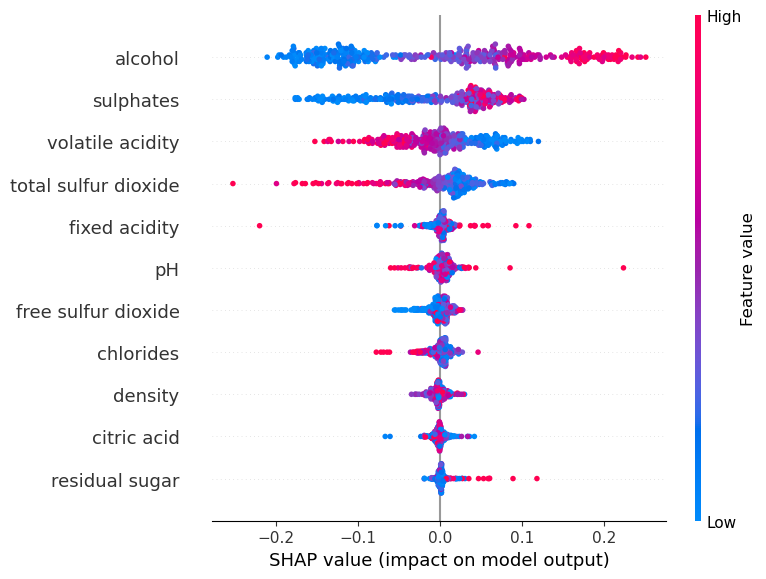

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

Как видно из графиков, признаки ***alcohol***, ***sulphates***, ***volatile acidity***, ***total sulfur dioxide*** имеют наибольшее влияние на принятие решений по классификации. Остальные признаки показывают значения уже более близкие к 0.

* Чем выше крепость вина, тем больше вклад в то, что вино - хорошее.
* Низкое содержание сульфитов (консервантов) в большинстве своем говорит нам о том, что скорее всего вино плохое.
* Низкое содержание летучих кислот в вине - хорошое вино.
* Общее содержание диоксида серы на высоком уровне - альтернатива пастеризации для защиты вина от преждевременной порчи. Высокое содержание диоксида серы скорее говорит нам о том, что вино все-таки не очень качественное.

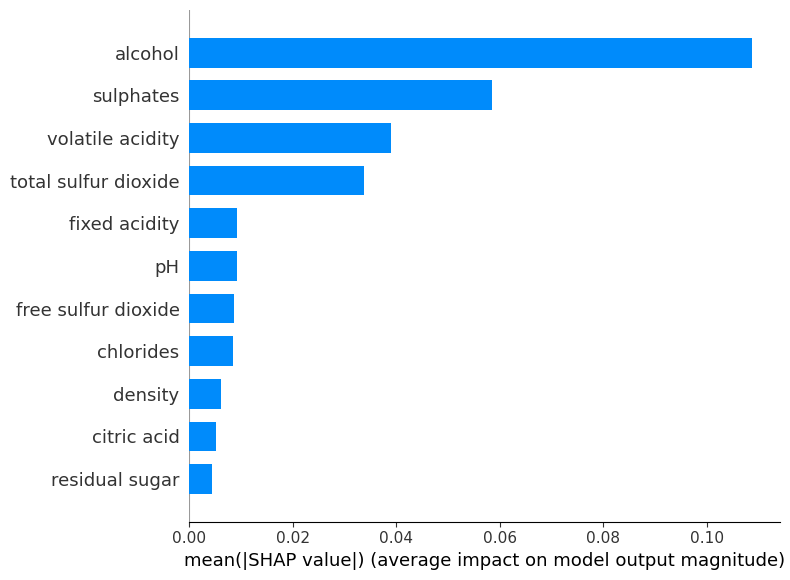

In [11]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

**Пять случайных объектов**

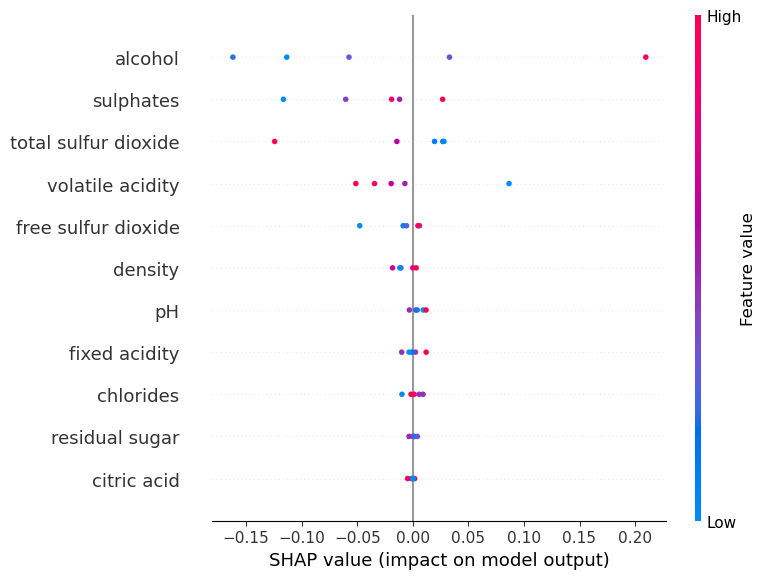

In [12]:
samp = X_test.sample(5)
shap_values_samp = explainer.shap_values(samp)
shap.summary_plot(shap_values_samp, samp)

При использовании только пяти случайных объектов все вышеуказанное остается справедливым, но становится более детальным и четким для понимания.

## Задание №6

In [13]:
idx = 111
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

Выше видим, что у вина высокая вероятность быть хорошим (0.82) и видим вклад признаков:
* Крепость вина выше среднего и это тянет его вероятность вверх.
* Низкое значение летучих кислот, отображенных в виде показателя 0.29, также тянет вероятность вверх.
* А вот небольшое количество сульфитов наоборот - тянет вероятность вниз.

In [14]:
idx = 55
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

У данного вина вероятность быть хорошим довольно низкая (0.29) и особый вклад внесли следующие признаки:
* Крепость ниже обычного - уменьшение вероятности
* Небольшое количество сульфитов (консервантов) - уменьшение вероятности.
* А вот низкое значение показателя летучих кислот - плюс.

---